# Implement Portfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [2]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]

In [3]:
risky_r.shape

(228, 3)

In [4]:
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.shape

(228, 3)

In [6]:
safe_r[:] = 0.03/12

In [7]:
start = 1000
floor = 0.8

1. Cushion -> (Asset Value - Floor Value)
2. Compute an Allocation to Safe and Risky Assets -> m * risk budget
3. Recompute the Asset Value based on the returns

In [8]:
def compound1(r):
    return (1 + r).prod() - 1

def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [9]:
compound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [10]:
compound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [11]:
%timeit compound1(risky_r)

318 µs ± 5.74 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%timeit compound2(risky_r)

290 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


 ### Back to CPPI

In [15]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value) / account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    
    ## update the account value for this time step
    account_value = (risky_alloc * (1 + risky_r.iloc[step])) + (safe_alloc * (1 + safe_r.iloc[step]))
    
    ## save the values so I can look at the history
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

In [16]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


In [17]:
risky_wealth = start * (1 + risky_r).cumprod()

<Axes: >

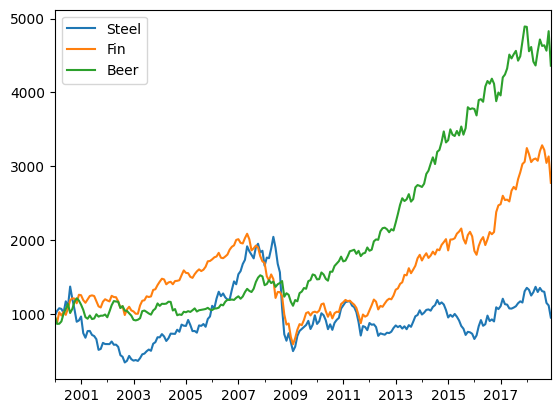

In [18]:
risky_wealth.plot()

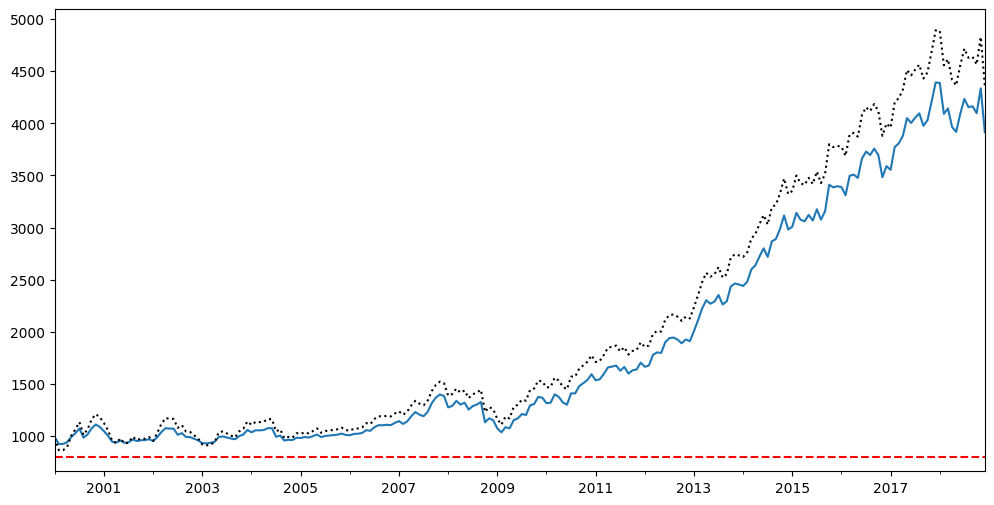

In [19]:
ax = account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

<Axes: >

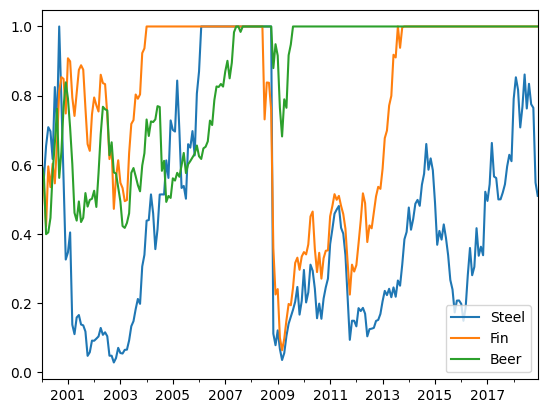

In [20]:
risky_w_history.plot()

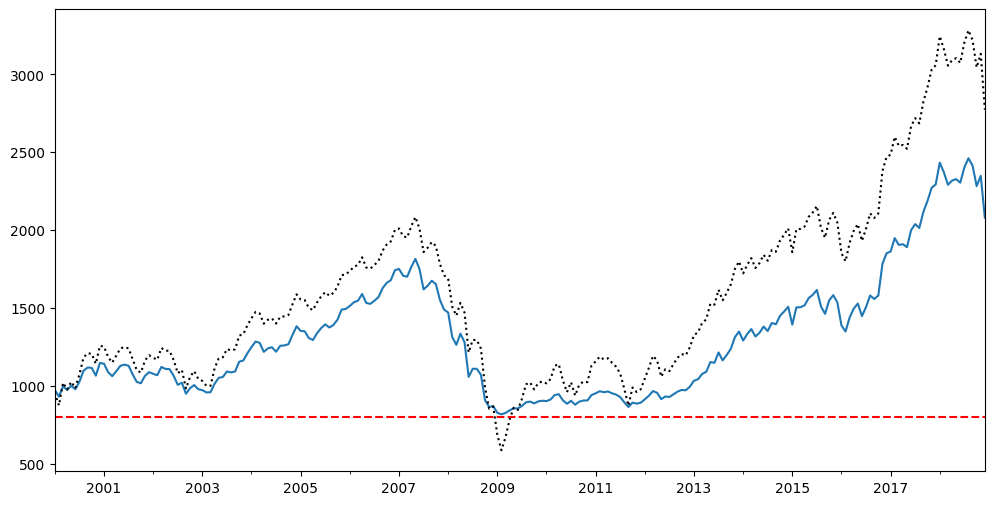

In [21]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

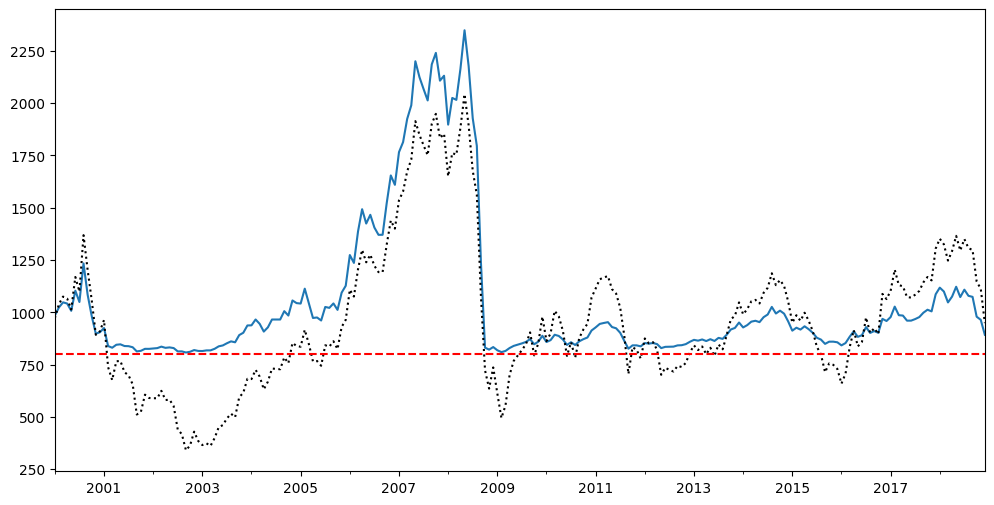

In [22]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color="r", linestyle="--")

In [23]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.145245,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.086286,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.059724,0.091442,0.354314,-0.271368


In [28]:
btr = erk.run_cppi(risky_r)
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.075313,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.059552,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.049213,0.074908,0.383772,-0.259582


<Axes: >

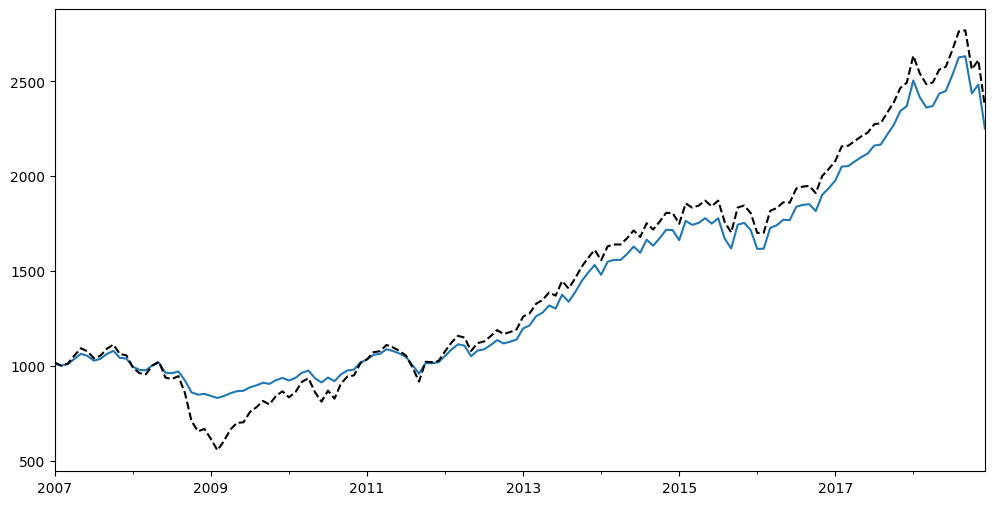

In [29]:
btr = erk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(figsize=(12, 6), legend=False)
btr["Risky Wealth"].plot(ax=ax, style="k--", legend=False)

In [30]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.06629,0.096315,0.280618,-0.499943


In [31]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.042847,0.062953,0.382052,-0.229683


# Drawdown Constraint

In [32]:
btr = erk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)


<Axes: >

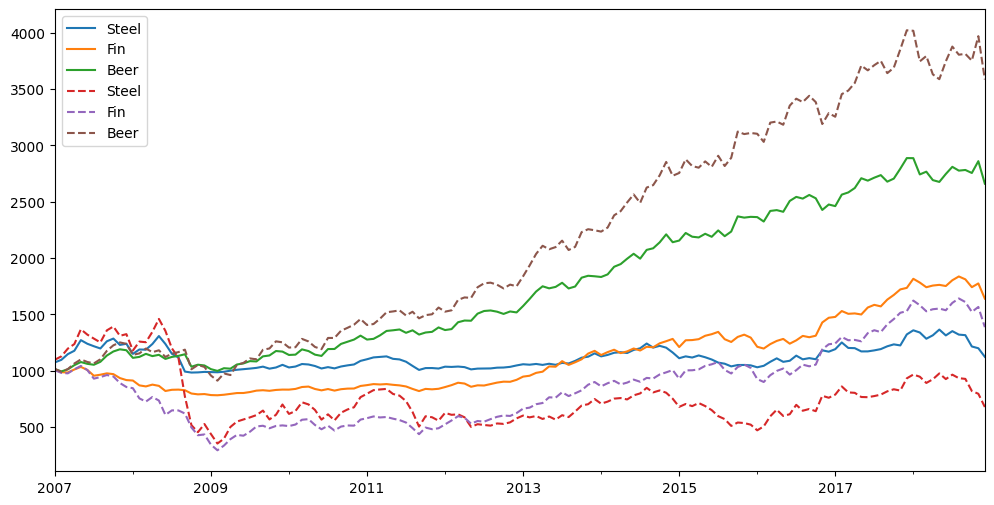

In [33]:
ax = btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [34]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.145531,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.098671,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.052381,0.077388,0.620132,-0.271368


In [35]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skweness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.045318,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.036894,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.034860,0.051189,0.613413,-0.161186
